The FaceNet system can be used to extract high-quality features from faces, called face embeddings, that can then be used to train a face identification system.
Face detection system using FaceNet and an SVM classifier to identify people from photographs.
It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.
The focus on training a model to create embeddings directly (rather than extracting them from an intermediate layer of a model) was an important innovation in this work.
We will use the pre-trained Keras FaceNet model provided by Hiroki Taniai in this tutorial. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.
https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn download model
Download the model file and place it in your current working directory with the filename ‘facenet_keras.h5‘. 

In [1]:
import tensorflow as tf

In [33]:
model=tf.keras.models.load_model('model/facenet_keras.h5')
print(model.input)
print(model.output)

Tensor("input_1:0", shape=(None, 160, 160, 3), dtype=float32)
Tensor("Bottleneck_BatchNorm/Identity:0", shape=(None, 128), dtype=float32)


In [39]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Before we can perform face recognition, we need to detect faces.
we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection,

In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 436kB/s eta 0:00:01
     |████████████████████████████████| 378kB 342kB/s eta 0:00:01


In [2]:
import mtcnn

Using TensorFlow backend.


In [3]:
import cv2
from matplotlib import pyplot as plt

In [29]:
def extract_faces(img_path):
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    faces=detector.detect_faces(img)
    # extract the bounding box from the first face
    x1, y1, width, height = faces[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    m_in=cv2.resize(face,(160,160))
    return m_in
    

In [4]:
import os 

In [51]:
path_train='data/train/'
path_val='data/val/'
x_train=[]
x_test=[]
y_train=[]
y_test=[]
for x in os.listdir(path_train):
    for y in os.listdir(path_train+x):
        img_path=path_train+x+'/'+y
        m_in=extract_faces(img_path)
        x_train.append(m_in)
        y_train.append(x)
for x in os.listdir(path_val):
    for y in os.listdir(path_val+x):
        img_path=path_val+x+'/'+y
        m_in=extract_faces(img_path)
        x_test.append(m_in)
        y_test.append(x)
        
    
    

In [5]:
import numpy as np

In [53]:
x_train=np.array(x_train).reshape(-1,160,160,3)
x_test=np.array(x_test).reshape(-1,160,160,3)
y_train=np.array(y_train).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1)

In [54]:
print(x_train.shape,x_test.shape,y_test.shape,y_train.shape)

(93, 160, 160, 3) (25, 160, 160, 3) (25, 1) (93, 1)


In [6]:
from numpy import savez_compressed

In [57]:
savez_compressed('5-celebrity-faces-dataset.npz', x_train, y_train, x_test, y_test)

In [18]:
data=np.load('5-celebrity-faces-dataset.npz')

In [19]:
x_train,y_train,x_test,y_test=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(93, 160, 160, 3) (93, 1) (25, 160, 160, 3) (25, 1)


In [13]:
def get_embeddings(face_img):
    face=face_img.astype('float32')
    f_mean,f_std=face.mean(),face.std()
    face_nor=(face-f_mean)/(f_std)
    face_nor=tf.expand_dims(face_nor,axis=0)
    y_out=model.predict(face_nor)
    return y_out

In [15]:
get_embeddings(x_train[0]).shape

(1, 128)

In [23]:
train_embed=[]
test_embed=[]
for x in x_train:
    e=get_embeddings(x)
    train_embed.append(e)
for x in x_test:
    e=get_embeddings(x)
    test_embed.append(e)
    

In [24]:
train_embed=np.asarray(train_embed)
test_embed=np.asarray(test_embed)

In [25]:
print(train_embed.shape)
print(test_embed.shape)


(93, 1, 128)
(25, 1, 128)


In [26]:
train_embed=train_embed.reshape(93,128)
test_embed=test_embed.reshape(25,128)

In [27]:
print(train_embed.shape)
print(test_embed.shape)

(93, 128)
(25, 128)


In [29]:
savez_compressed('5-celebrity-faces-embeddings.npz',train_embed,y_train,test_embed,y_test )

In [7]:
final_data=np.load('5-celebrity-faces-embeddings.npz')
X_train,y_train,X_test,y_test=final_data['arr_0'],final_data['arr_1'],final_data['arr_2'],final_data['arr_3']

In [8]:
print(X_train.shape)

(93, 128)


In [9]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [10]:
in_encod=Normalizer('l2')
x_train_norm=in_encod.transform(X_train)
x_test_norm=in_encod.transform(X_test)

In [11]:
out_encod=LabelEncoder()
out_encod.fit(y_train)
y_train_int=out_encod.transform(y_train)
y_test_int=out_encod.transform(y_test)

/home/umarkhan/anaconda3/envs/umar_analyst/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/umarkhan/anaconda3/envs/umar_analyst/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
y_test_int

array([4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2])

In [15]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train_norm,y_train_int)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [29]:
yhat_train = model.predict(x_train_norm)
y_out_train=out_encod.inverse_transform(yhat_train)
yhat_test = model.predict(x_test_norm)
y_out_test=out_encod.inverse_transform(yhat_test)
yhat_test_proba=model.predict_proba(x_test_norm)
# score
score_train = accuracy_score(y_train_int, yhat_train)
score_test = accuracy_score(y_test_int, yhat_test)
print('on training data :',score_train*100,' on test data :',score_test*100)

on training data : 100.0  on test data : 100.0


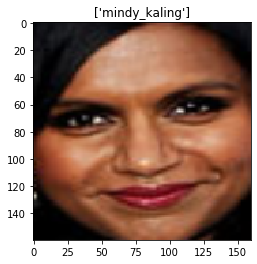

prediction :  mindy_kaling
prediction probability : 91.07876398788176


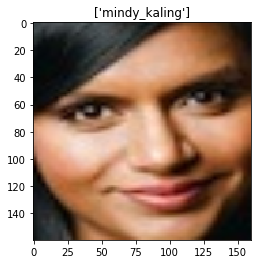

prediction :  mindy_kaling
prediction probability : 91.43879322390818


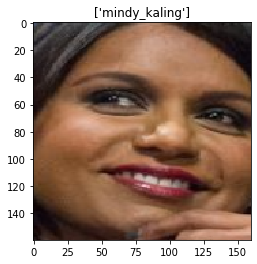

prediction :  mindy_kaling
prediction probability : 93.0851771052282


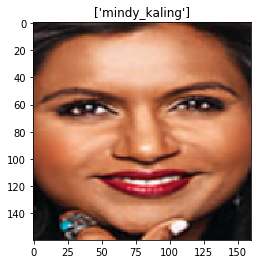

prediction :  mindy_kaling
prediction probability : 90.5927592293544


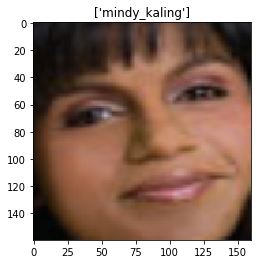

prediction :  mindy_kaling
prediction probability : 81.05432289567


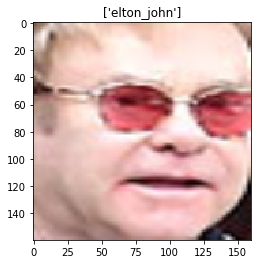

prediction :  elton_john
prediction probability : 91.30264811544048


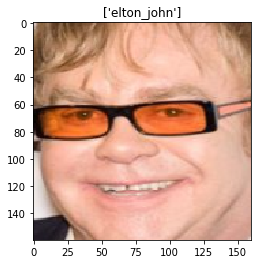

prediction :  elton_john
prediction probability : 91.15791584066577


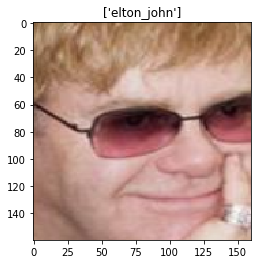

prediction :  elton_john
prediction probability : 90.4244593954331


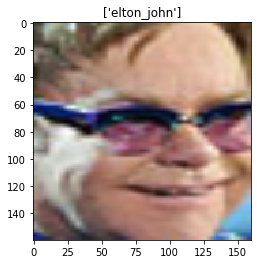

prediction :  elton_john
prediction probability : 90.94392720032312


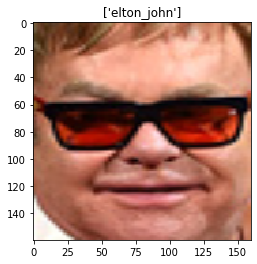

prediction :  elton_john
prediction probability : 89.63890822743056


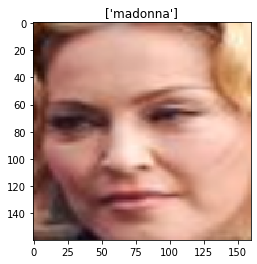

prediction :  madonna
prediction probability : 81.62153456097022


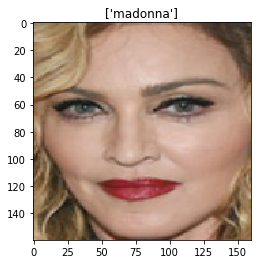

prediction :  madonna
prediction probability : 87.25918247666644


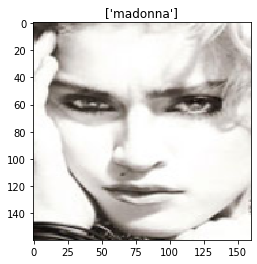

prediction :  madonna
prediction probability : 86.43483598008068


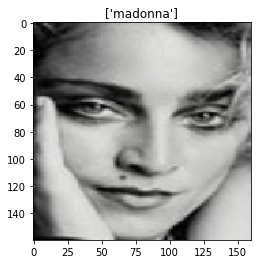

prediction :  madonna
prediction probability : 76.7294499662966


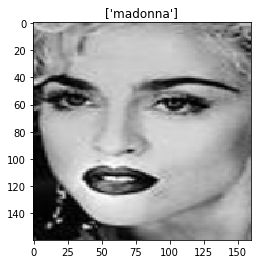

prediction :  madonna
prediction probability : 80.14428151228302


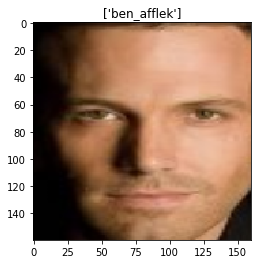

prediction :  ben_afflek
prediction probability : 87.64076650174758


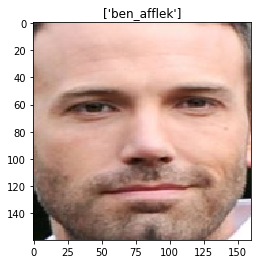

prediction :  ben_afflek
prediction probability : 87.27658809305429


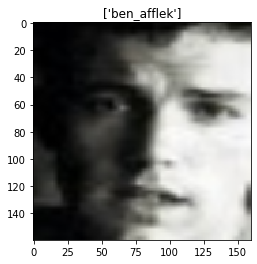

prediction :  ben_afflek
prediction probability : 70.51181007615114


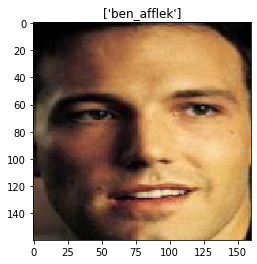

prediction :  ben_afflek
prediction probability : 87.31410425893654


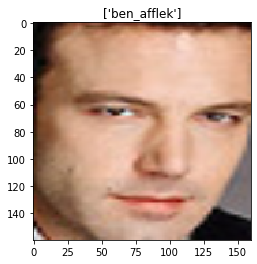

prediction :  ben_afflek
prediction probability : 87.16928355010984


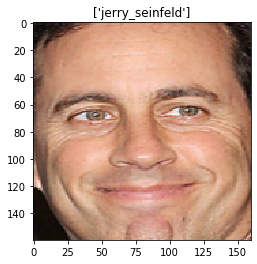

prediction :  jerry_seinfeld
prediction probability : 89.87885404690282


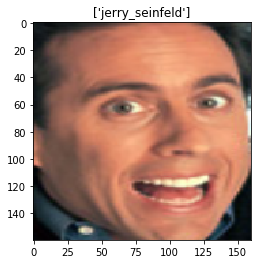

prediction :  jerry_seinfeld
prediction probability : 74.42444455556095


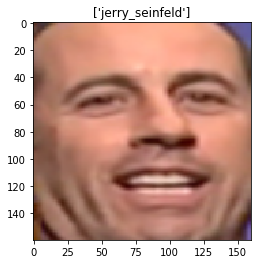

prediction :  jerry_seinfeld
prediction probability : 88.23663792898584


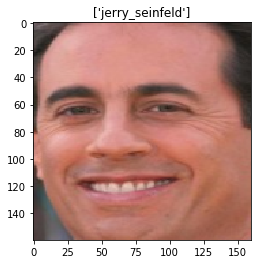

prediction :  jerry_seinfeld
prediction probability : 90.95673967311299


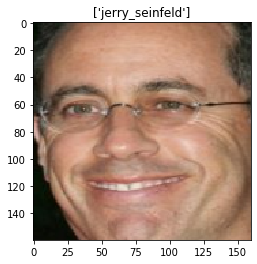

prediction :  jerry_seinfeld
prediction probability : 85.06447754093736


In [31]:
for x in range(len(x_test)):
    plt.imshow(x_test[x])
    plt.title(y_test[x])
    plt.show()
    print('prediction : ',y_out_test[x])
    print('prediction probability :',yhat_test_proba[x].max()*100)

    